The below iPython NoteBook is made for Google Collaboratory. Each part is to be run only after the preceding parts have finished running.

The first part of the code shows the loading IMDB data, model creation, semi-supevised/supervised training processes. It also shows the accuracy after 10 epochs. 

Possible Customizations:
The num_words, skip_words, semi-supervised to supervised learning, the percentage of samples to use for supervised learning, the model file name whenever you make a new model, and the number of CNN layers to change the model. 

In [0]:
# LSTM and CNN for sequence classification on the IMDB dataset
import os
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from math import floor
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
skip_top_words = 0 # 20
semi_supervised = True  #change to false for supervised learning


# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, skip_top=skip_top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

all_data = numpy.append(X_train, X_test, axis=0)
all_label = numpy.append(y_train, y_test, axis=0)
print(all_data.shape, all_label.shape)
data_len = len(all_data)

if semi_supervised ==True:
  #semi-supervised : self training
  #partition data into labeled and unlabeled
  print("Using Semi-Supervised Learning")
  first_part = floor(0.1*data_len)
  second_part = floor(0.8*data_len)
  thrid_part = floor(1*data_len)

  
else:
  #supervised learning
  print("Using Supervised Learning")
  use_percentage = 0.1 # adjust the float value to decide the percentage of labeled data used
  first_part = floor(use_percentage*data_len)  
  second_part = floor(use_percentage*data_len)
  thrid_part = floor(1*data_len)

partition_indexes = [[range(0,first_part)], [range(first_part, second_part)], [range(second_part, thrid_part)]]

l_data_x = all_data[partition_indexes[0]] # labeled_data
u_data_x = all_data[partition_indexes[1]] # unlabeled_data
t_data_x = all_data[partition_indexes[2]] # test_data

l_data_y = all_label[partition_indexes[0]] 
u_data_y = all_label[partition_indexes[1]]
t_data_y = all_label[partition_indexes[2]]

print("Original : Labeled : Unlabeled > ",X_train.shape, y_train.shape, l_data_x.shape, l_data_y.shape, u_data_x.shape, u_data_y.shape)

 

model_file_name = "best_model_4cnn_1dense_skip_model_semisupervised.hdf5"
times = 10
for curr_time in range(times):
    print("Iteration", curr_time)
    # create the model
    path = "/content/" + model_file_name
    if (os.path.exists(path)):
      model = load_model(path)
      print("model loaded from "+path)
      if semi_supervised == True:
        print("adding unlabeled data by self-training")
        predicted_y = model.predict(u_data_x)
        new_data_x = []
        new_data_y = []
        threshold = 0.2
        for i,y in enumerate(predicted_y):
          if y<threshold or y>(1.0-threshold):
            new_data_x.append(u_data_x[i])
            new_data_y.append(0 if y<threshold else 1)

        print("new data added for training: ", len(new_data_y))
        
        if new_data_x !=[]:
          l_data_x = numpy.append(l_data_x, numpy.asarray(new_data_x), axis=0)
          l_data_y = numpy.append(l_data_y, numpy.asarray(new_data_y), axis=0)

        # shuffle the updated data
        indices = numpy.arange(len(l_data_x))
        numpy.random.shuffle(indices)
        l_data_x = l_data_x[indices]
        l_data_y = l_data_y[indices]
    else:
      print("building a new model")
      embedding_vecor_length = 32
      model = Sequential()
      model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
      model.add(Dropout(0.2))
      model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Dropout(0.2))
      model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Dropout(0.2))
      model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Dropout(0.2))
      model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Dropout(0.2))
      model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      print(model.summary())
    checkpoint = ModelCheckpoint(model_file_name, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)
    model.fit(l_data_x, l_data_y, epochs=2, batch_size=64, callbacks=[checkpoint])
# Final evaluation of the model
scores = model.evaluate(t_data_x, t_data_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


#/content/best_model.hdf5
#/content/best_model_cnn.hdf5



The below code is for evaluation and in-depth understanding of the working of the above model.

First, the dictionary for word to index mapping is extracted and used to print what a typical training data sample might look like and how it is interpreted by the model.

Then using the same procedure, a generic test string is created and passed to model and the prediction is printed. 

Possible Customizations:
The generic text string could be anything given by the user. For now, only simple format is supported, i.e. spaces before and after ".", so that it can be marked as <UNK> and does not affect the sequence much.

In [0]:
''' For Evaluation '''

NUM_WORDS=top_words # only use top 1000 words
INDEX_FROM=3   # word index offset
import numpy as np
# train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
# train_x,train_y = train
# test_x,test_y = test

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
print("Example Training Data Sample")
print(' '.join(id_to_word[id] for id in X_train[0] ))

# print(X_train[0])

### Uncomment the below sentence to evaluate a generic positive or negative string

# new_in = "I liked the film a lot . There were some excellent scenes showing spaceflight and superheores . The actors were well suited for their roles . This movie definiltely deserves an Oscar ."
new_in = "The movie was so bad I walked out of the theatre after an hour . The acting and dialogs were abysmal . There was no story to be followed . This was a waste of time ."
new_in = new_in.lower()
print(new_in)
new_in = new_in.split()  # This could be improved
words = [w if w in word_to_id else "<UNK>" for w in new_in]
# print(words)
# index_from = INDEX_FROM  # Already added in word_to_id
index_from = 0 # Already added in word_to_id
#replace words by their freq + index_from
in_vec = [word_to_id[word] + index_from for word in words]
# print(in_vec)
max_review_length = 500
in_vec = [word_to_id["<START>"]] + in_vec
in_vec = [in_vec]

oov_char = 2
skip_top = skip_top_words
num_words = top_words
if oov_char is not None:
  for i in range(len(in_vec)):
    in_vec[i] = [w if (skip_top <= w < num_words) else oov_char for w in in_vec[i]]
else:
    in_vec = [[w for w in x if skip_top <= w < num_words] for x in in_vec]

#adjust the sequence length
new_x = np.asarray(in_vec)
# new_x = new_x.transpose()
new_x = sequence.pad_sequences(new_x, maxlen=max_review_length)
# new_x = []
# for x in in_vec:
#   new_x.append([x])
  
# print(new_x)
print("Prediction on Generic Test String not belonging to the  Dataset")
# print(new_x)  # print the new input tensor
print(' '.join(id_to_word[id] for id in new_x[0] ))
prediction = model.predict(new_x)

print("Predicted value is: " + str(prediction))

Example Training Data Sample
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The below code is for checking the difficult cases.

Possible customizations:


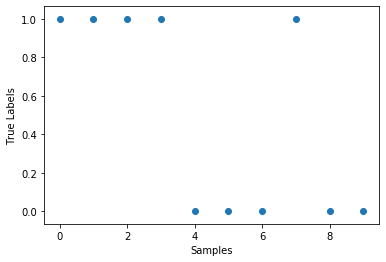

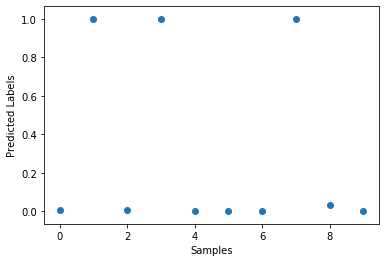

In [0]:
predicted_y = model.predict(t_data_x)  # calculate the predicted values on the test data

import matplotlib.pyplot as plt

# data = {'a': np.arange(50),
#         'c': np.random.randint(0, 50, 50),
#         'd': np.random.randn(50)}
# data['b'] = data['a'] + 10 * np.random.randn(50)
# data['d'] = np.abs(data['d']) * 100

start = 0
end = 10
data = {'a':np.arange(start, end), 'b':t_data_y[start:end]}

plt.scatter('a', 'b', data=data)
plt.xlabel('Samples')
plt.ylabel('True Labels')
plt.show()

data = {'a':np.arange(start, end), 'b':predicted_y[start:end]}

plt.scatter('a', 'b', data=data)
plt.xlabel('Samples')
plt.ylabel('Predicted Labels')
plt.show()


The below code is to print the difficult cases.

Possible customizations:
The index of the test data to print.

In [0]:
def vec2string(in_vec):
  NUM_WORDS=top_words # only use top 1000 words
  INDEX_FROM=3   # word index offset
  # train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
  # train_x,train_y = train
  # test_x,test_y = test

  word_to_id = imdb.get_word_index()
  word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
  word_to_id["<PAD>"] = 0
  word_to_id["<START>"] = 1
  word_to_id["<UNK>"] = 2
  word_to_id["<UNUSED>"] = 3

  id_to_word = {value:key for key,value in word_to_id.items()}
  return ' '.join(id_to_word[id] for id in in_vec )

index_to_study = 2  # change the index to which string you want print out based on the plots above
difficult_str = vec2string(t_data_x[index_to_study])  
print(difficult_str)

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD